# Identifying Non-Temporal Patterns Across Datasets

In [44]:
import sys
import re
import glob
import spacy
import statistics
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pprint as pp
from IPython.display import Markdown, display
# from liwc import Liwc
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
from spacy.lang.en import English
from matplotlib import rcParams
from collections import Counter
warnings.filterwarnings('ignore')
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

#### Set up Printing and Plot Formats

In [2]:
rcParams['font.family'] = 'monospace'
rcParams['font.size'] = 16
# rcParams['font.monospace'] = ['Courier']
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.titlesize'] = 14

In [3]:
nlp = spacy.load("en_core_web_sm")
def printmd(string):
    display(Markdown(string))

## Read files
Read all formatted files into a dataframe.

In [4]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df_init = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df_init.shape[0], "rows into the dataframe.")
df_init[0:5]

Read 65 files and loaded 20902 rows into the dataframe.


,dataset,session,speaker,utterance
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn."
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...


## Identify Indicators of hypotheticals
The next few cells define functions to identify the occurrences of hypotheticals in every utterance in the datasets, and add the counts as columns to the existing dataframe.

In [5]:
hypothetical_indicators = ["would", "could", "'d",  "can", "might", "may", "if", "then", "unless"]

liwc_tentative = ["pretty", "confused", "hesitant", "hopefully", "confusing", "hoping",
    "doubt", "doubting", "hope", "confuse", "hoped", "luck", "lucky", "any",
    "questions", "kind of", "probably", "something", "or", "anything",
    "may", "some", "try", "perhaps", "if", "possible", "bet", "guess",
    "anyhow", "most", "quite", "might", "sort", "somewhat", "assuming",
    "supposed", "seem", "somebody", "maybe", "someone", "assume", "trying",
    "lot", "question", "sometimes", "option", "dunno", "approximately",
    "sorta", "generally", "options", "possibility", "kinda", "overall",
    "seems", "wondering", "somewhere", "sometime", "assumption",
    "potentially", "possibly", "optional", "optionally", "mostly", "almost",
    "depending", "often", "seemed", "potential", "temporarily",
    "occasionally", "wonder", "someone's", "lots", "opinion", "apparently",
    "somehow", "somebody's", "suppose", "barely", "usually", "random",
    "vary", "anywhere", "puzzle", "practically", "fairly", "wondered",
    "depends", "appears", "unknown", "assumed", "probablyâ", "unlikely",
    "mainly", "something's", "vaguely", "sorts", "theory", "chance",
    "typically", "possibleâ", "confusion", "virtually", "anyone",
    "appearing", "depend", "anybody", "likely", "unclear", "supposing",
    "possibilities", "appear", "alot", "border", "assumes", "guessing",
    "hardly", "anytime", "temporary", "randomly", "lotta", "hypothetical",
    "contingent", "someday", "undecided", "hypothesize", "blurred",
    "variable", "theoretically", "partly", "borderline", "variables",
    "feasible", "confusions", "somethingo", "mystery", "questioning",
    "assumptions", "possibilites", "betting", "indirectly", "supposedly",
    "varies", "vague", "temporally", "indirect", "puzzling"]

def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches
    

In [6]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print

def count_every_lexicon_term(sentence, lexicon):
    list_of_counts = []
    for term in lexicon:
        count_obj = { 'term' : term, 'count' : 0 }
        if term == "'d" :
            reg_string = term
        else :
            reg_string = "\\b" + term + "\\b"
        count_obj['count'] = len(list(re.finditer(reg_str, sentence)))
        list_of_counts.append(count_obj)
    return list_of_counts

def count_lexicon_term(sentence, term):
    if term == "'d" :
        reg_str = term
    else :
        reg_str = "\\b" + term + "\\b"
    term_count = len(list(re.finditer(reg_str, sentence)))
    return term_count

    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')

In [7]:
def add_count(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    category_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            category_measure = count_lexicon_terms(utterance, lex_category_list)
            category_measures.append(category_measure)
    df.insert(column_index, lex_category_name, category_measures, True)
    return df

def add_every_count(df, lex_category_name, lex_category_list, normalize_measure=False):
    column_index = len(df.columns)
    for term in lex_category_list :
        term_measures = []
        if term in df.columns :
            print("Column already exists for", lex_category_name, ". Repopulating...")
            df = df.drop(lex_category_name, axis=1)
        for ind, utterance in enumerate(list(df['utterance'])) :
            if utterance != '' and utterance != ' ' :
                term_measure = count_lexicon_term(utterance, term)
                term_measures.append(term_measure)
        df.insert(column_index, term, term_measures, True)
        column_index = len(df.columns)
    return df

In [8]:
# df = add_count(df_init, 'hypotheticals', hypothetical_indicators)
df = add_count(df_init, 'hypotheticals', liwc_tentative)
# df_e = add_every_count(df_init, 'hypotheticals', hypothetical_indicators)

In [9]:
df[0:5]

,dataset,session,speaker,utterance,hypotheticals
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0


## Compute Proportions of Hypotheticals for each Dataset
Create a separate dataframe called `df_counts` that stores the number and percentage of lines with and without hypotheticals.

In [10]:
df_counts = pd.DataFrame(columns = ['dataset', 'type', 'line count', 'percentage'])
dataset_list = list(set(list(df['dataset'])))
hyp_terms = [col for col in df.columns 
                  if not col in ['dataset', 'session', 'speaker', 'utterance', 'hypotheticals']]
for dataset in dataset_list :
    df1 = df[df['dataset'] == dataset]
    category_column = df1['hypotheticals']
    non_category_count = sum(category_count == 0 for category_count in category_column)
    category_count = len(category_column) - non_category_count
    total = len(category_column)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'hypotheticals', 
        'line count' : category_count, 
        'percentage' : round(category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'non hypotheticals', 
        'line count' : non_category_count, 
        'percentage' : round(non_category_count/total * 100, 2)
    }, ignore_index=True)
    df_counts = df_counts.append({
        'dataset' : dataset, 
        'type' : 'total', 
        'line count' : total, 
        'percentage' : round(total/total * 100, 2)
    }, ignore_index=True)
    for term in hyp_terms :
        term_column = df1[term]
        term_count = len([c for c in term_column if c != 0])
        df_counts = df_counts.append({
            'dataset' : dataset, 
            'type' : term, 
            'line count' : term_count, 
            'percentage' : round(term_count/total * 100, 2)
        }, ignore_index=True)
        
    

df_counts = df_counts.sort_values("dataset")
df_counts[0:20]

,dataset,type,line count,percentage
3,dtrs-02,hypotheticals,773,29.89
4,dtrs-02,non hypotheticals,1813,70.11
5,dtrs-02,total,2586,100.00
6,dtrs-07,hypotheticals,1400,29.58
7,dtrs-07,non hypotheticals,3333,70.42
8,dtrs-07,total,4733,100.00
9,dtrs-10,hypotheticals,1394,26.93
10,dtrs-10,non hypotheticals,3782,73.07
11,dtrs-10,total,5176,100.00
0,dtrs-11,hypotheticals,2921,34.74


## Plot Counts for All Datasets
We pad the y-axis labels for greater (size) consistency with additional plots of sessions below.

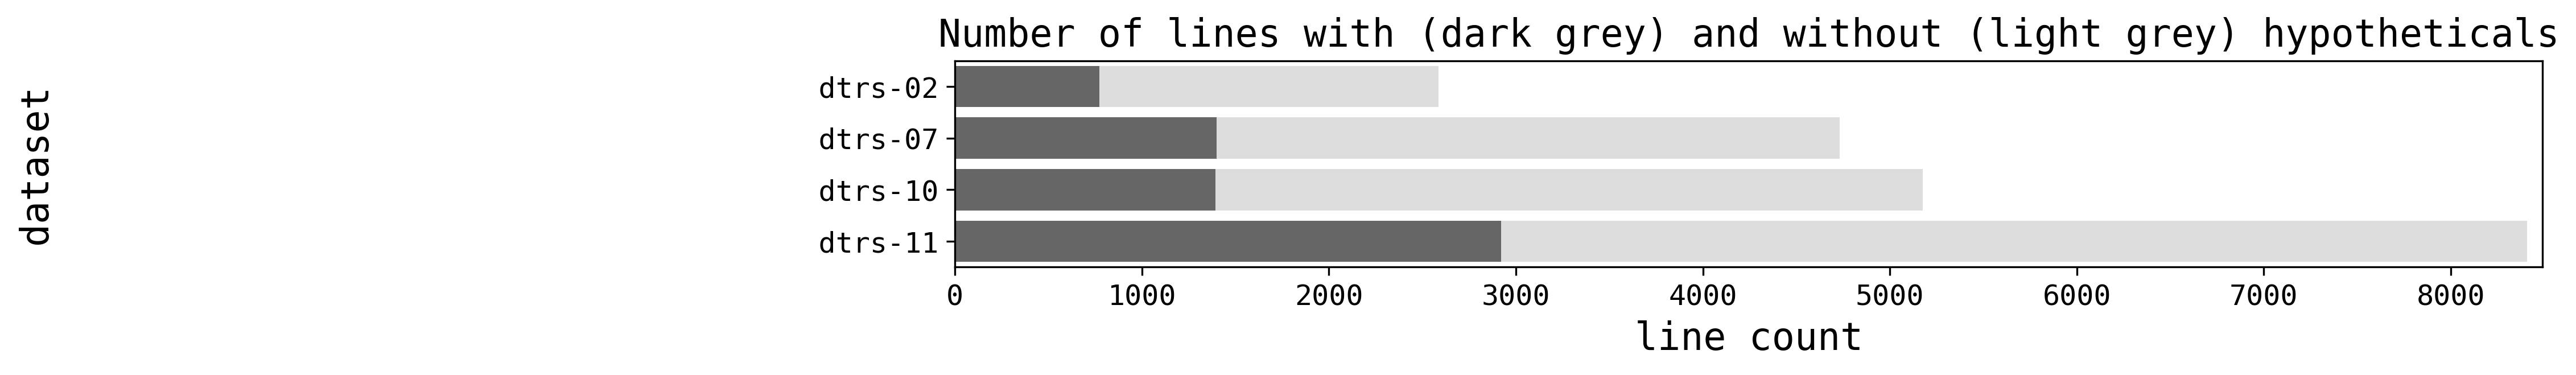

In [11]:
fig, ax = plt.subplots(figsize=(12, 1.6), dpi=300)
overall_hyp_color = '#666666'
session_names = list(df['session'])
unique_session_names = list(set(session_names))
session_name_maxlen = len(max(unique_session_names, key=len))
bars = sns.barplot(x = 'line count', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars = sns.barplot(x = 'line count', y = 'dataset', color = overall_hyp_color,
                   data = df_counts[df_counts.type == 'hypotheticals'])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels_padded = [item.rjust(session_name_maxlen) for item in labels]
ax.set_yticklabels(labels_padded)
bars.set_xlim([0,max(list(df_counts['line count']))*1.01])
bars.set_title("Number of lines with (dark grey) and without (light grey) hypotheticals", fontsize=16)
print()

In [12]:
palette = sns.color_palette()

all_types = list(set(list(df_counts["type"])))
hyp_types = sorted([term for term in all_types if not term in ['hypotheticals', 'non hypotheticals', 'total']])
# print(hyp_types)


for ind, hyp_type in enumerate(hyp_types) :
    fig, ax = plt.subplots(figsize=(12, 1.6), dpi=300)
    session_names = list(df['session'])
    unique_session_names = list(set(session_names))
    session_name_maxlen = len(max(unique_session_names, key=len))
    bars = sns.barplot(x = 'line count', y = 'dataset', color = "#dddddd",
                       data = df_counts[df_counts.type == 'total'])
    df_filter = df_counts[df_counts.type == hyp_type]
    if 'plot' in df_filter.columns :
        df_filter['plot'] = list(df_filter['plot'] + df_filter['line count'])
    else :
        df_filter['plot'] = list(df_filter['line count'])
    bars = sns.barplot(x = 'line count', y = 'dataset', color = palette[ind],
                       data = df_filter)
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels_padded = [item.rjust(session_name_maxlen) for item in labels]
    ax.set_yticklabels(labels_padded)
    bars.set_xlim([0,max(list(df_counts['line count']))*1.01])
    bars.set_title("Number of lines with (color) and without (light grey) the term '"+hyp_type+"'", fontsize=16)
    print()


In [13]:
for ind, hyp_type in enumerate(hyp_types) :
    fig, ax = plt.subplots(figsize=(12, 1.6), dpi=300)
    session_names = list(df['session'])
    unique_session_names = list(set(session_names))
    session_name_maxlen = len(max(unique_session_names, key=len))
    bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#dddddd",
                       data = df_counts[df_counts.type == 'total'])
    df_filter = df_counts[df_counts.type == hyp_type]
    if 'plot' in df_filter.columns :
        df_filter['plot'] = list(df_filter['plot'] + df_filter['percentage'])
    else :
        df_filter['plot'] = list(df_filter['percentage'])
    bars = sns.barplot(x = 'percentage', y = 'dataset', color = palette[ind],
                       data = df_filter)
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels_padded = [item.rjust(session_name_maxlen) for item in labels]
    ax.set_yticklabels(labels_padded)
    bars.set_xlim([0,max(list(df_counts['percentage']))*1.01])
    bars.set_title("Percentage of lines with (color) and without (light grey) the term '"+hyp_type+"'", fontsize=16)
    print()

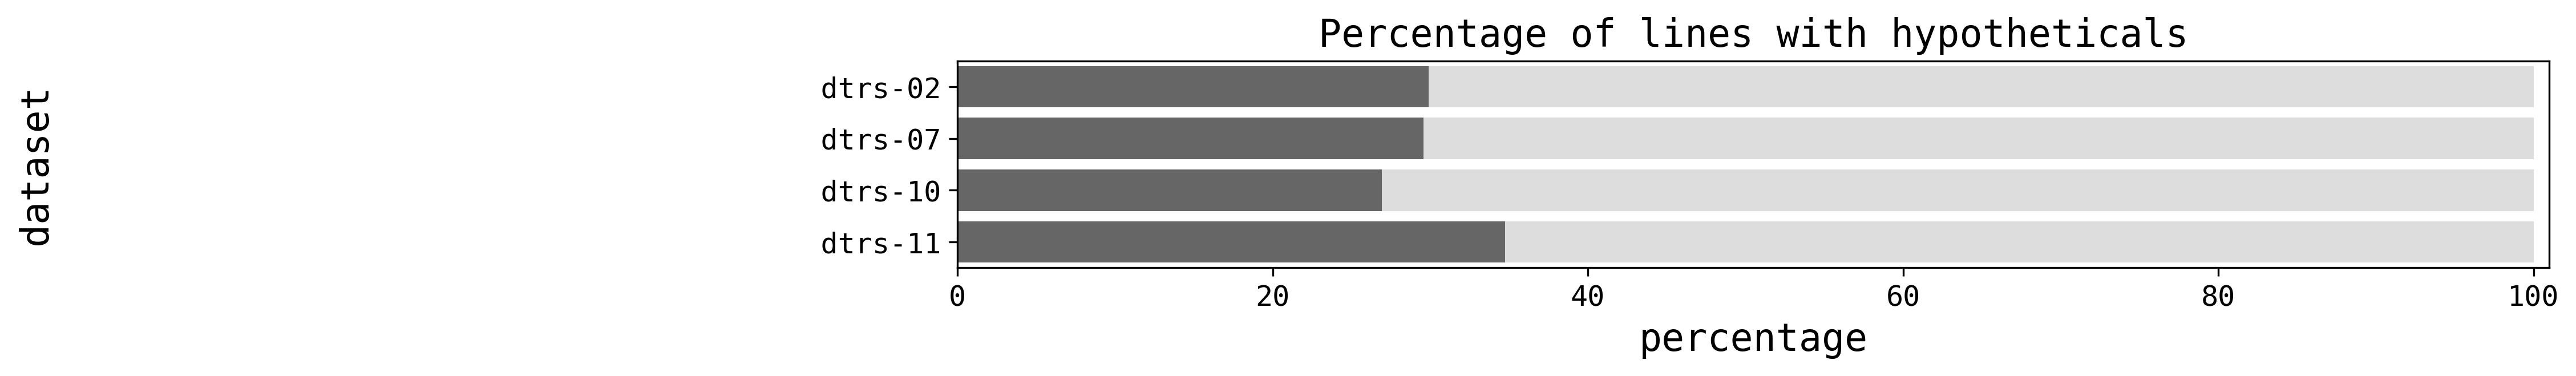

In [14]:
fig, ax = plt.subplots(figsize=(12, 1.6), dpi=300)
bars = sns.barplot(x = 'percentage', y = 'dataset', color = "#dddddd",
                   data = df_counts[df_counts.type == 'total'])
bars = sns.barplot(x = 'percentage', y = 'dataset', color = overall_hyp_color,
                   data = df_counts[df_counts.type == 'hypotheticals'])
labels = [item.get_text() for item in ax.get_yticklabels()]
labels_padded = [item.rjust(session_name_maxlen) for item in labels]
ax.set_yticklabels(labels_padded)
bars.set_title("Percentage of lines with hypotheticals", fontsize=16)
bars.set_xlim([0,101])
plt.savefig('./plots/hypotheticals_liwc.pdf', bbox_inches='tight')
print()

## Compute Proportions for each Session
Same as above, but this time at session-level

In [15]:
def session_counts(df, dataset):
    df_counts = pd.DataFrame(columns = ['dataset', 'session', 'type', 'line count', 'percentage'])
    df_dataset = df[df.dataset == dataset]
    sessions_list = list(set(list(df_dataset['session'])))
    for session in sessions_list :
        df1 = df_dataset[df_dataset.session == session]
        category_column = df1['hypotheticals']
        non_category_count = sum(category_count == 0 for category_count in category_column)
        category_count = len(category_column) - non_category_count
        total = len(category_column)
        df_counts = df_counts.append({
            'dataset' : dataset,
            'session' : session,
            'type' : 'hypotheticals', 
            'line count' : category_count, 
            'percentage' : round(category_count/total * 100, 2)
        }, ignore_index=True)
        df_counts = df_counts.append({
            'dataset' : dataset, 
            'session' : session,
            'type' : 'non hypotheticals', 
            'line count' : non_category_count, 
            'percentage' : round(non_category_count/total * 100, 2)
        }, ignore_index=True)
        df_counts = df_counts.append({
            'dataset' : dataset, 
            'session' : session,
            'type' : 'total', 
            'line count' : total, 
            'percentage' : round(total/total * 100, 2)
        }, ignore_index=True)
        for term in hyp_terms :
            term_column = df1[term]
            term_count = len([c for c in term_column if c != 0])
            df_counts = df_counts.append({
                'dataset' : dataset, 
                'session' : session,
                'type' : term, 
                'line count' : term_count, 
                'percentage' : round(term_count/total * 100, 2)
            }, ignore_index=True)
    df_counts = df_counts.sort_values("session")
    return df_counts

In [16]:
padded_session_names = [session_name.rjust(session_name_maxlen) for session_name in session_names]
padded_session_names[0:10]
df['session'] = padded_session_names

df[0:5]

,dataset,session,speaker,utterance,hypotheticals
0,dtrs-10,grad-2-concept-review-s...,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-s...,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-s...,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-s...,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-s...,Steve,You critique it. What’s working. Explain the...,0


## Plot Counts at Session Level

In [17]:
def plot_sessions(df, dataset_name, percentage=True):
    df_dataset = session_counts(df, dataset_name)
    bar_width = 0.4
    num_bars = len(set(list(df_dataset['session'])))
    plot_height = bar_width * num_bars
    fig, ax = plt.subplots(figsize=(12, plot_height), dpi=300)
    if percentage :
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#dddddd",
                           data = df_dataset[df_dataset.type == 'total'])
        bars = sns.barplot(x = 'percentage', y = 'session', color = overall_hyp_color,
                           data = df_dataset[df_dataset.type == 'hypotheticals'])
        bars.set_title("Percentage of lines in each dataset containing hypotheticals", fontsize=16)
        xmin = min(list(df_dataset.percentage))
        xmin = 0
        xmax = max(list(df_dataset.percentage)) * 1.01
        bars.set_xlim([xmin, xmax])
    else :
        bars = sns.barplot(x = 'line count', y = 'session', color = "#dddddd",
                           data = df_dataset[df_dataset.type == 'total'])
        bars = sns.barplot(x = 'line count', y = 'session', color = overall_hyp_color,
                           data = df_dataset[df_dataset.type == 'hypotheticals'])
        bars.set_title("Number of lines in each dataset containing hypotheticals", fontsize=16)
#         xmin = min(list(df_dataset['line count']))
        xmin = 0
        xmax = max(list(df_dataset['line count'])) * 1.01
        bars.set_xlim([xmin, xmax])
    plt.savefig('./plots/hypotheticals_liwc.pdf', bbox_inches='tight')

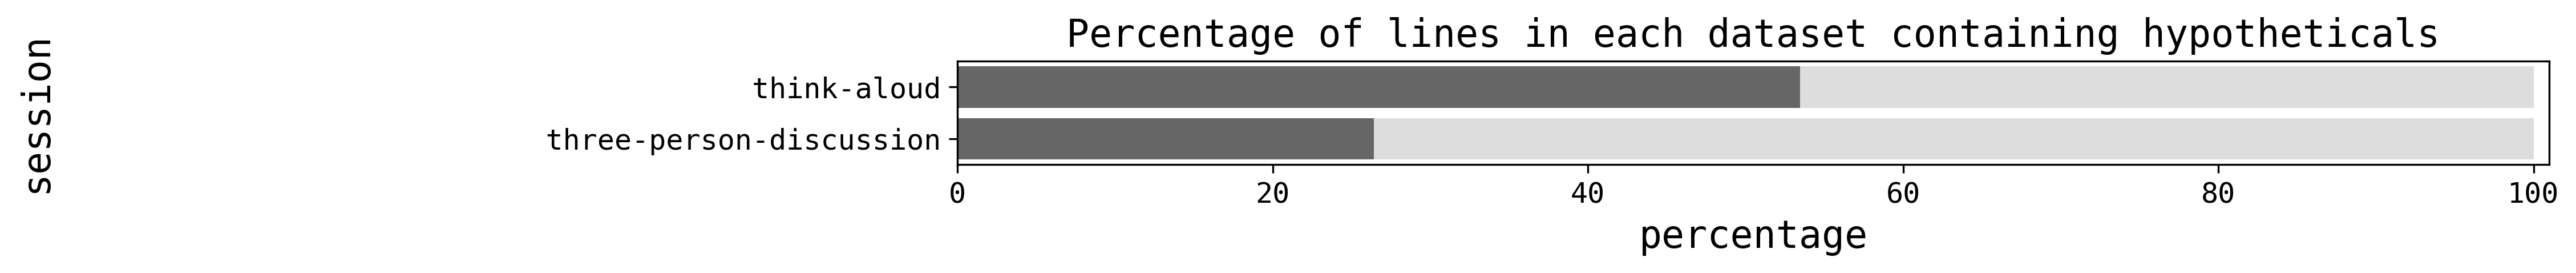

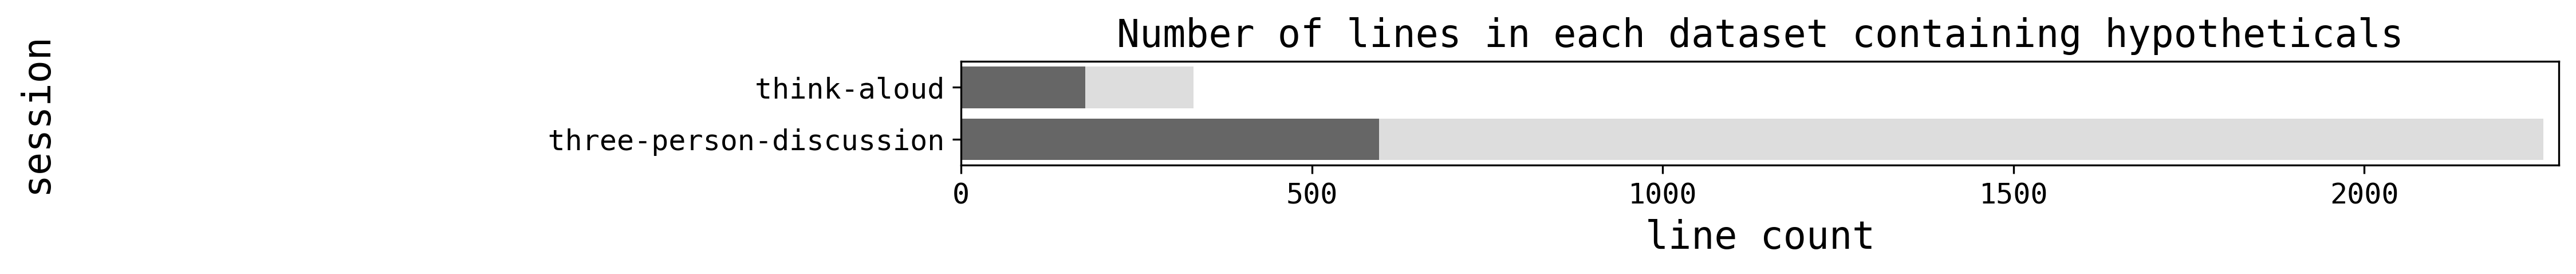

In [18]:
plot_sessions(df, 'dtrs-02')
plot_sessions(df, 'dtrs-02', percentage=False)

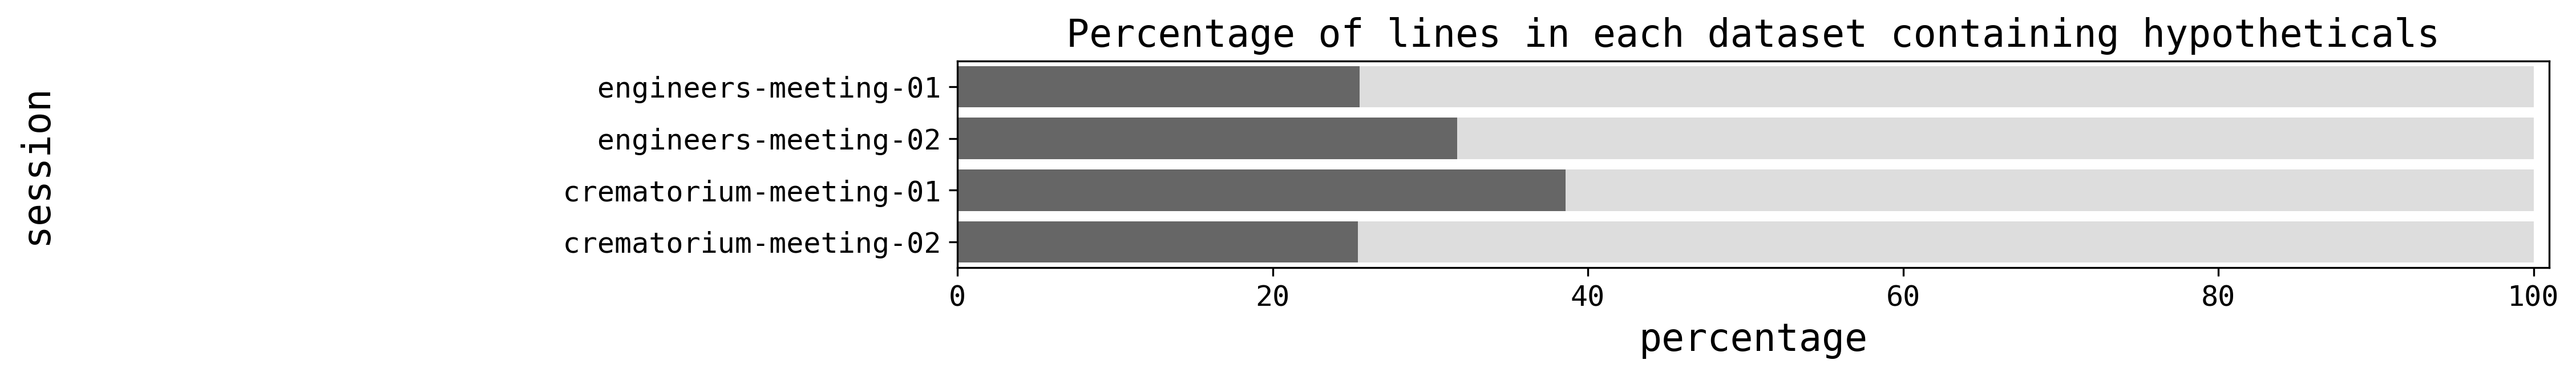

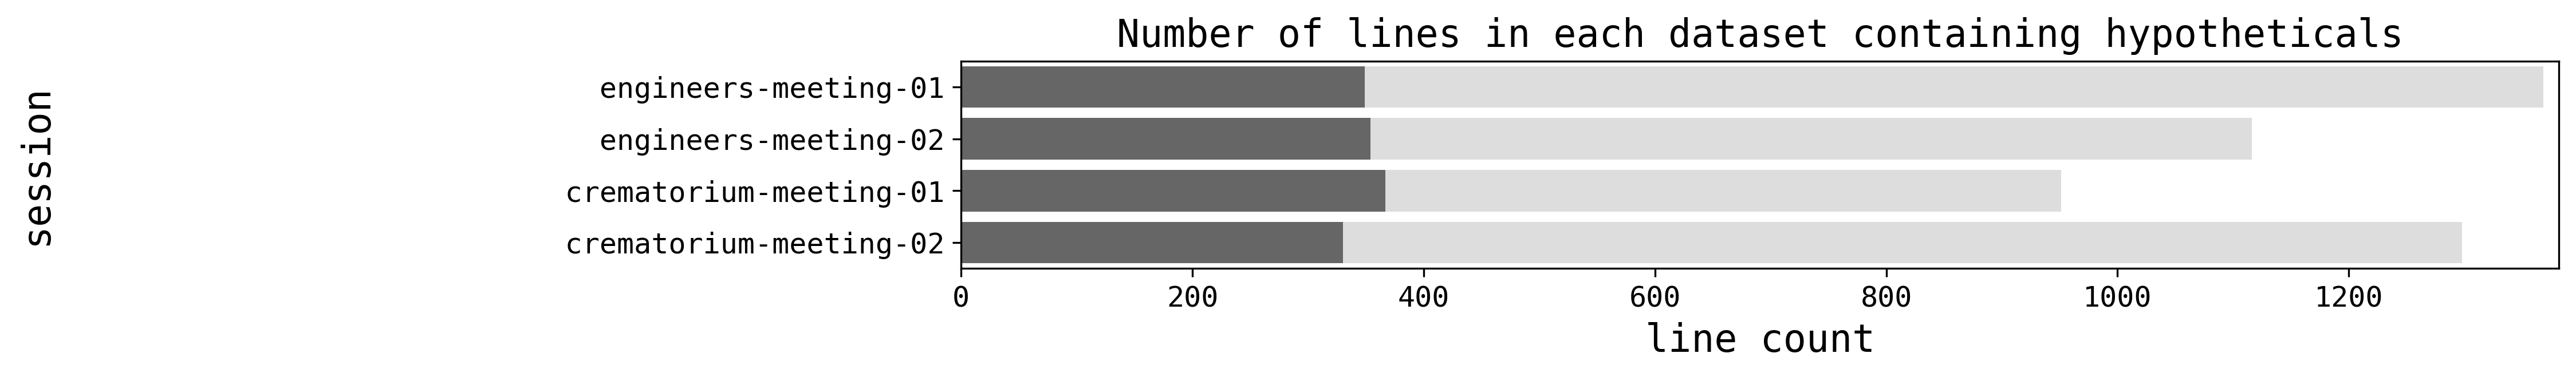

In [19]:
plot_sessions(df, 'dtrs-07')
plot_sessions(df, 'dtrs-07', percentage=False)

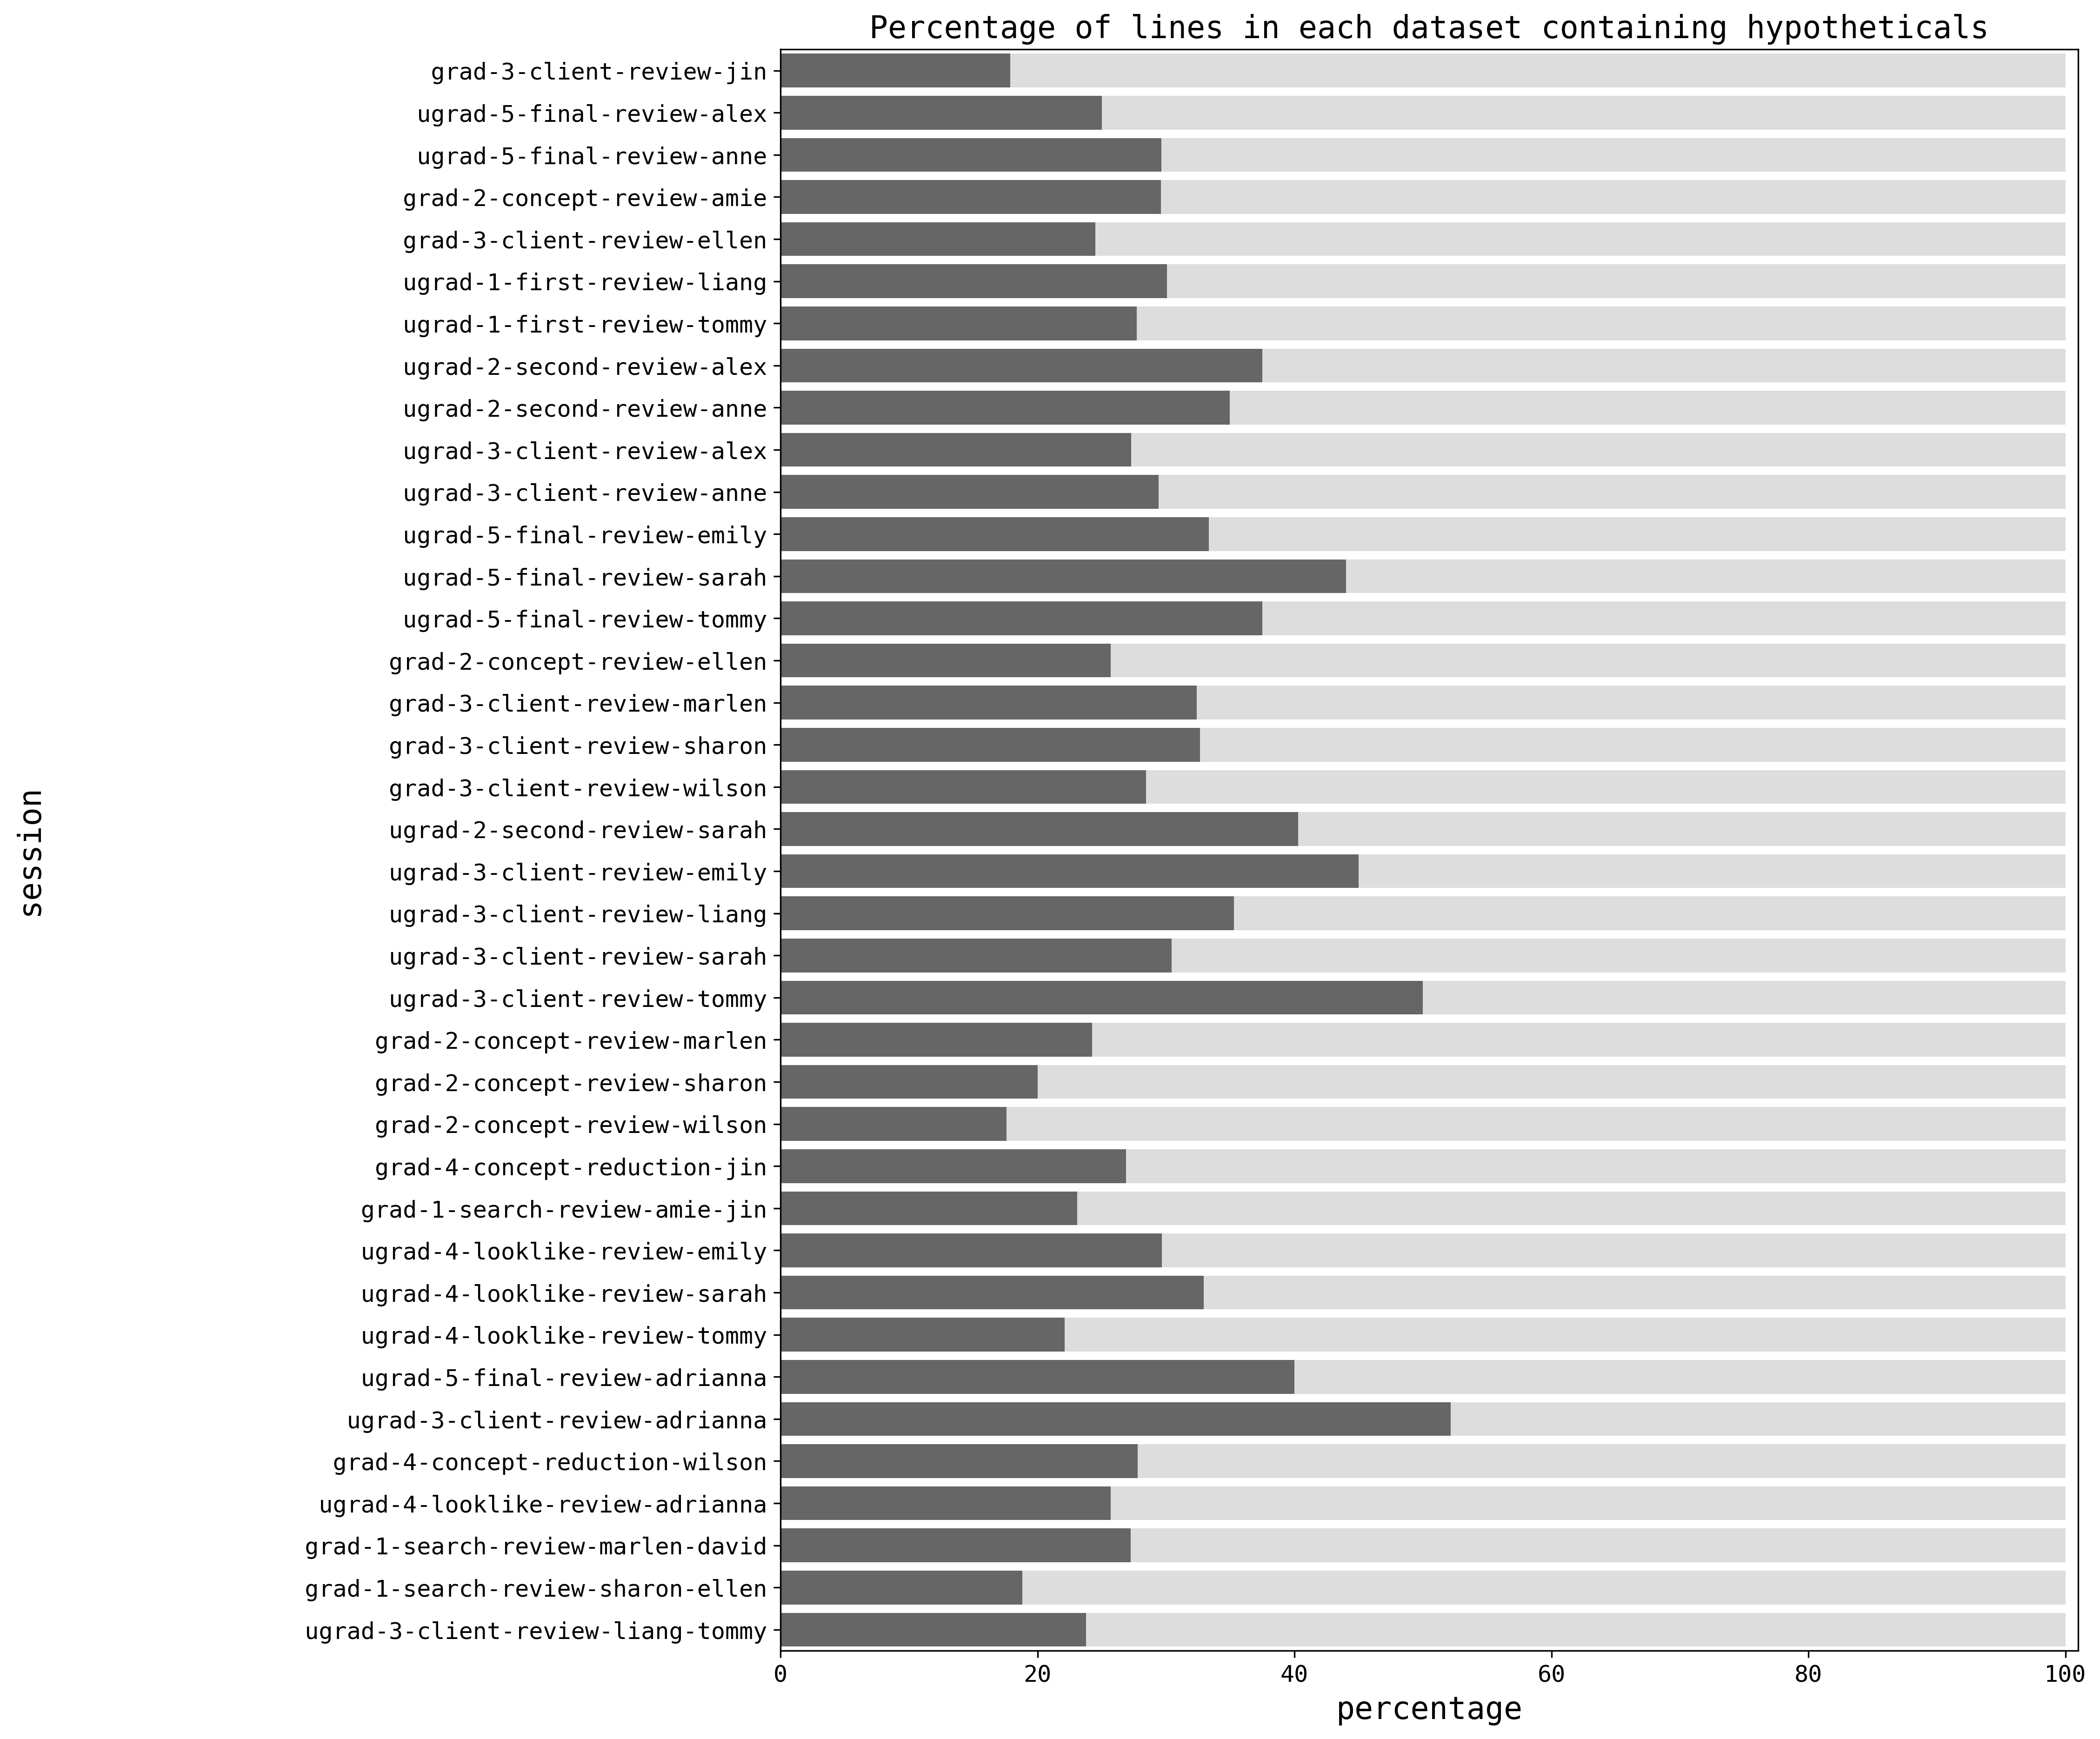

In [20]:
plot_sessions(df, 'dtrs-10')

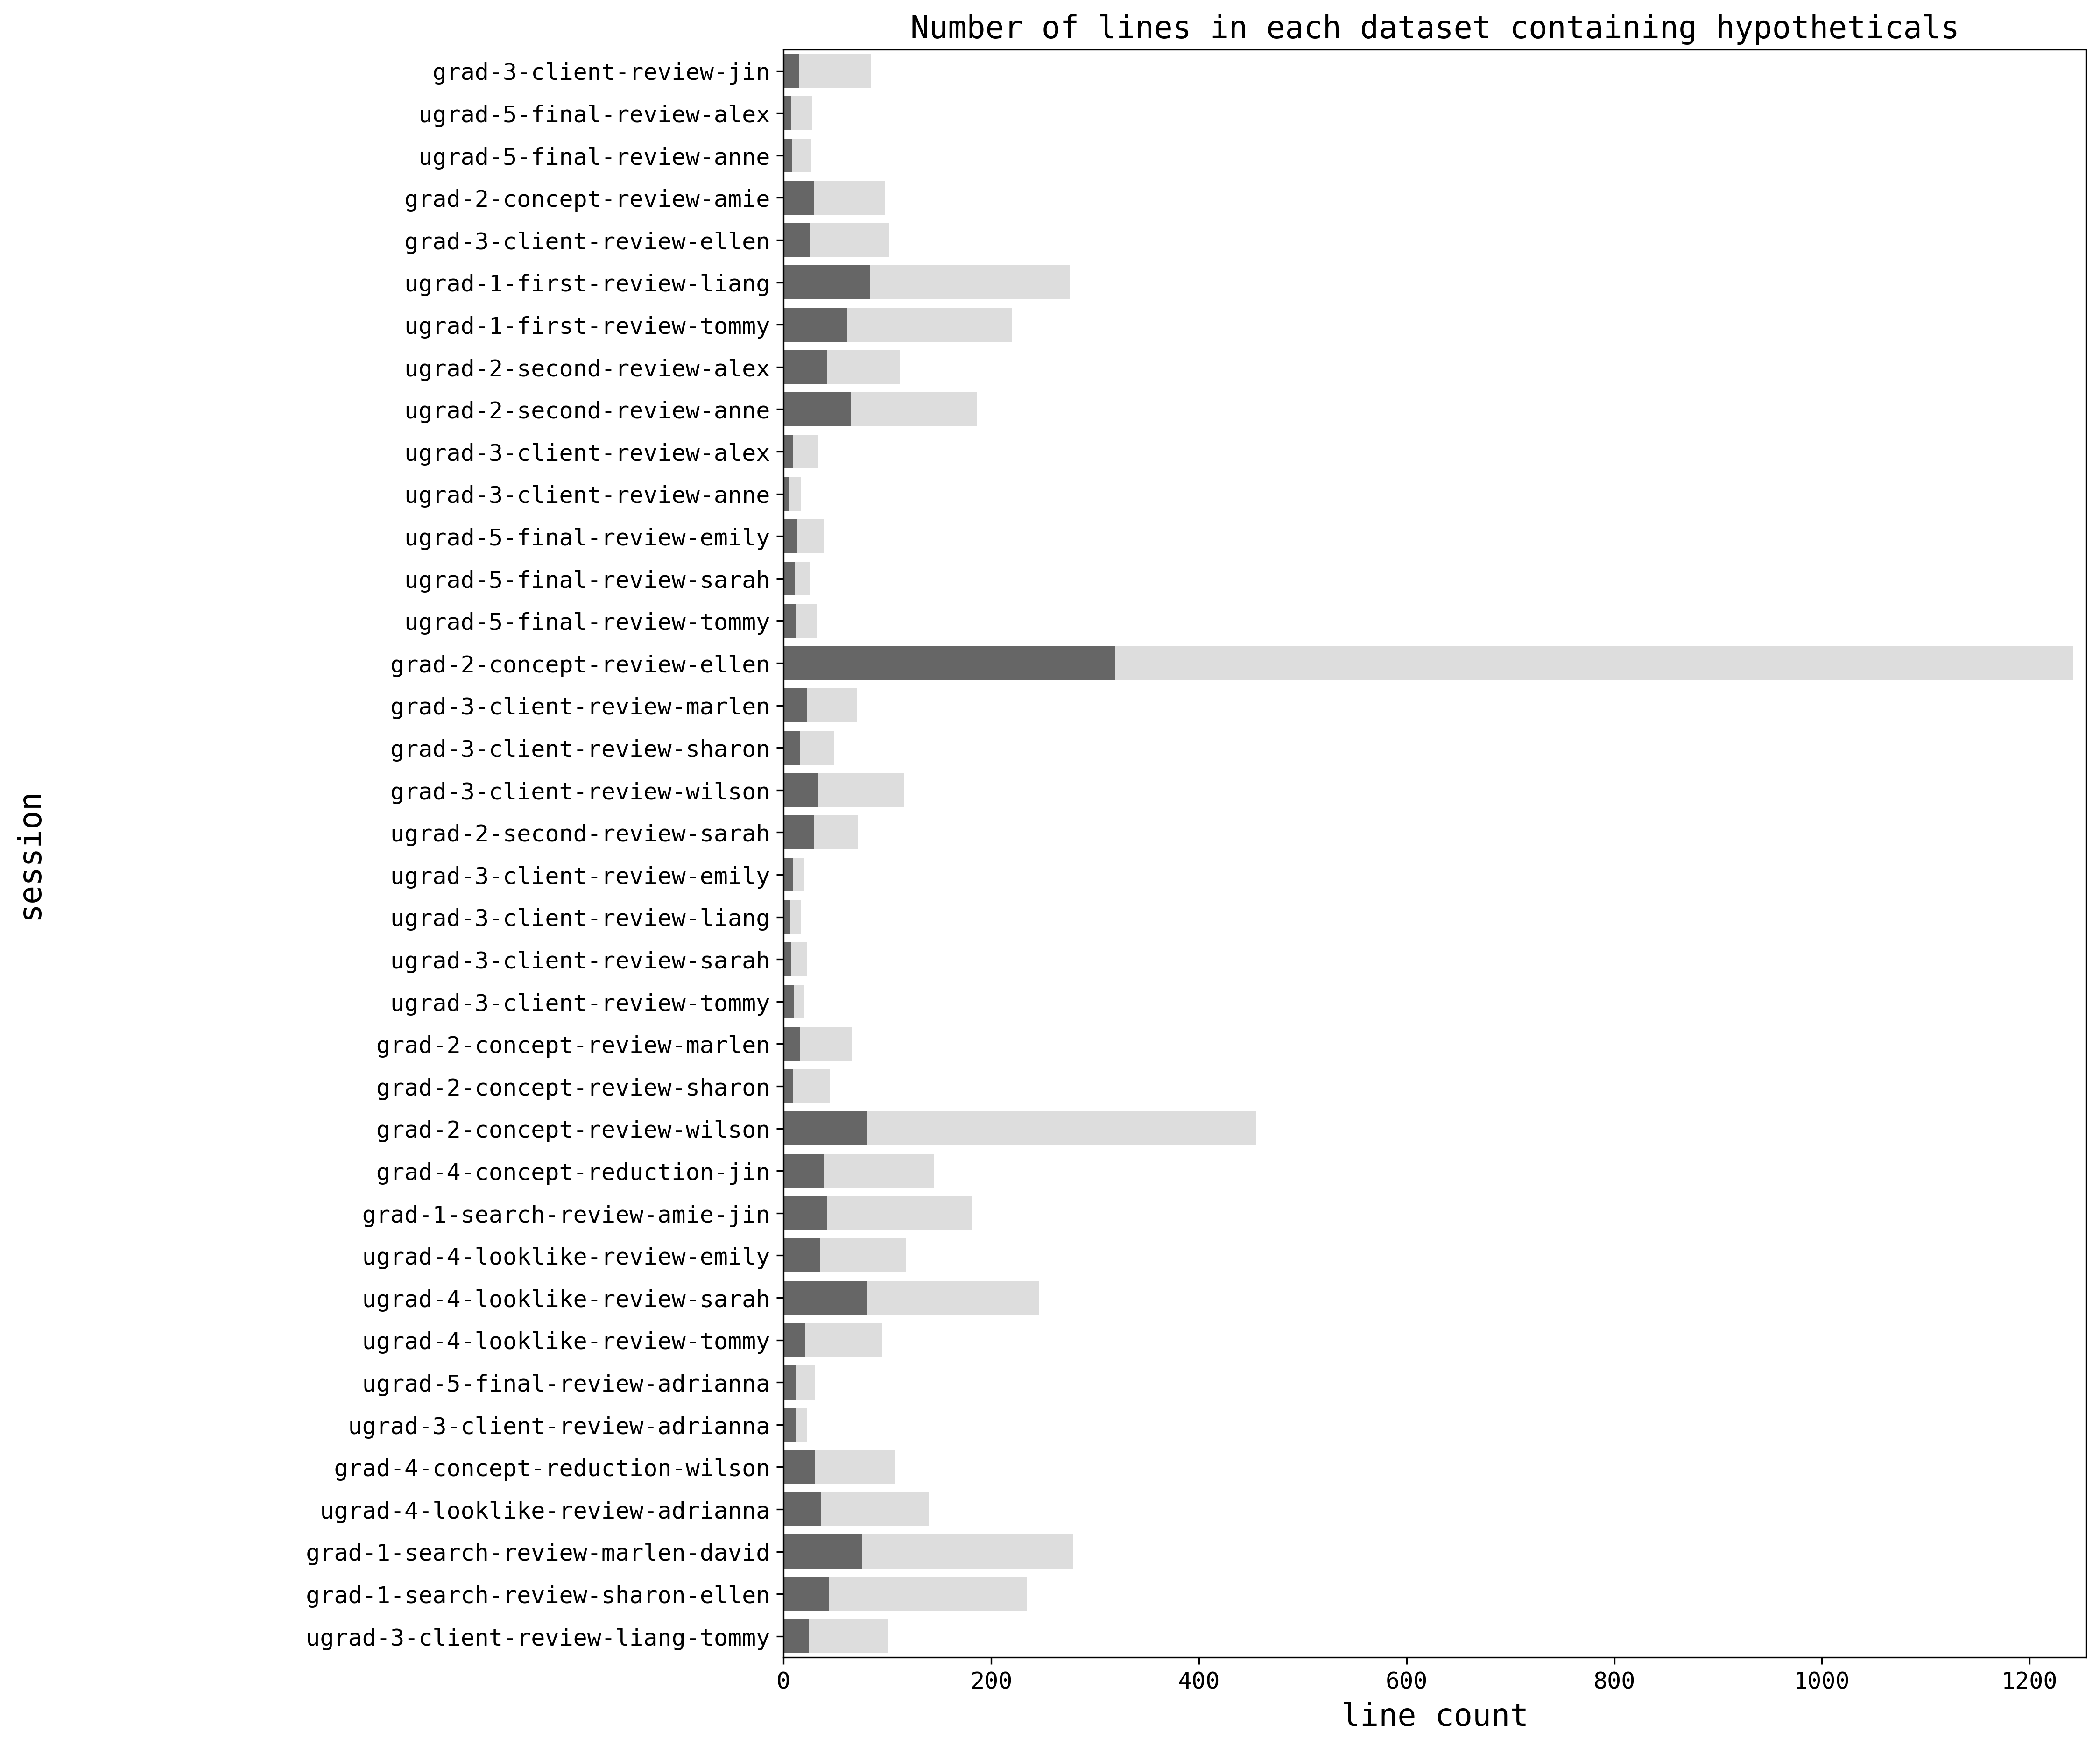

In [21]:
plot_sessions(df, 'dtrs-10', percentage=False)

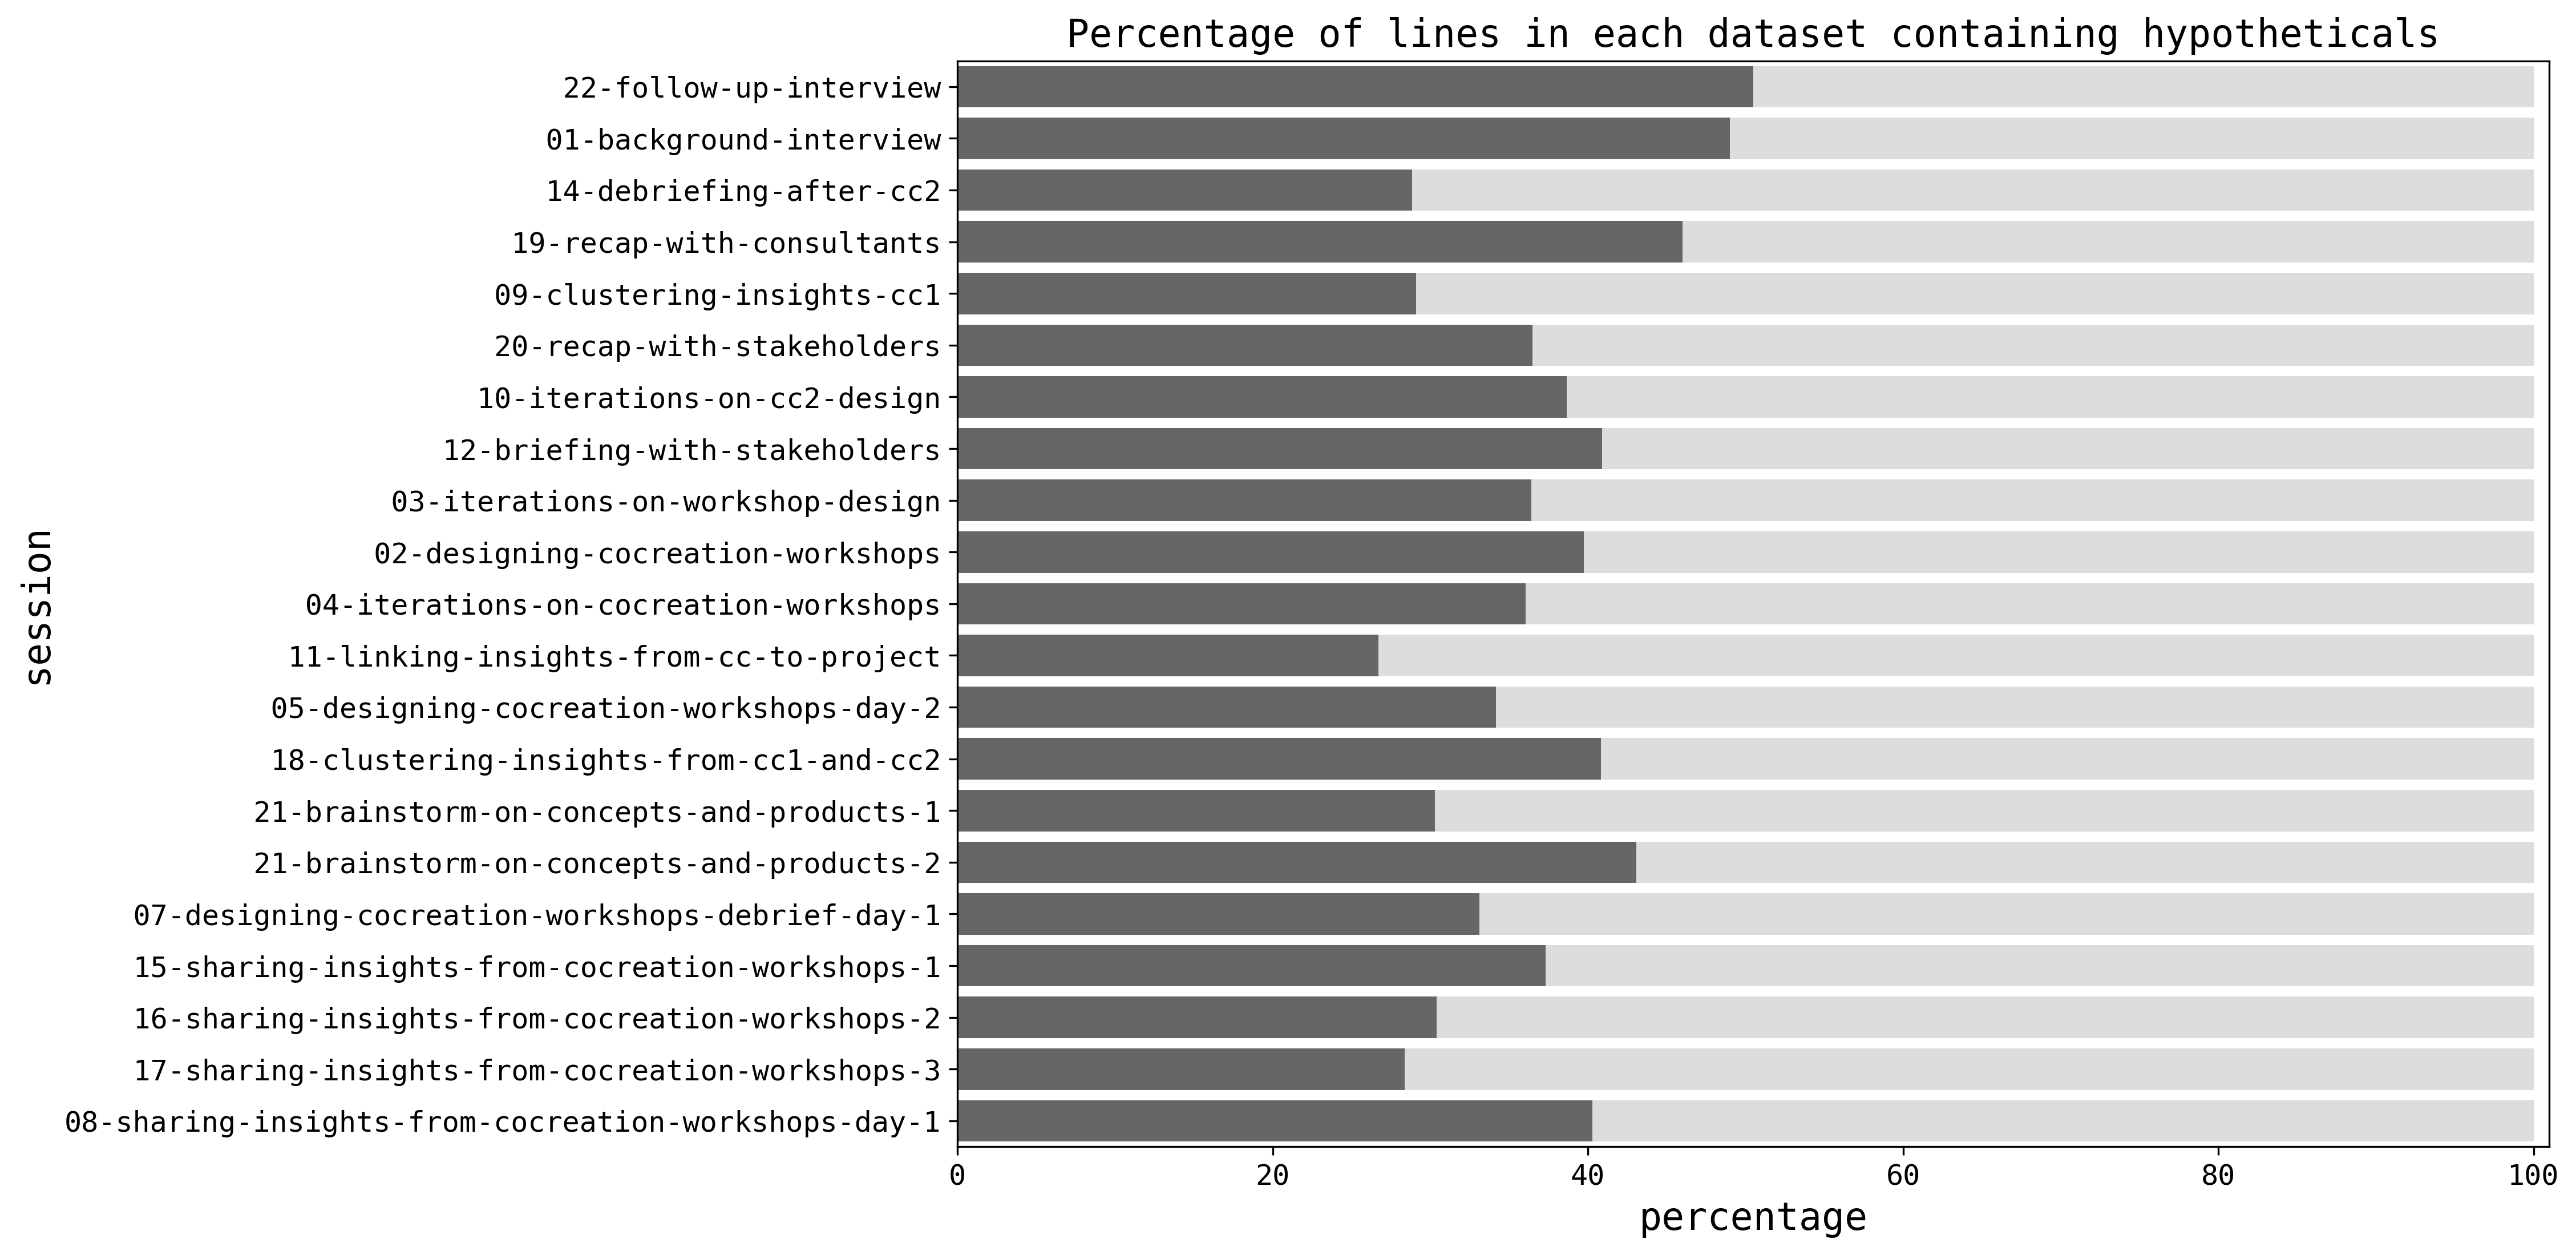

In [22]:
plot_sessions(df, 'dtrs-11')

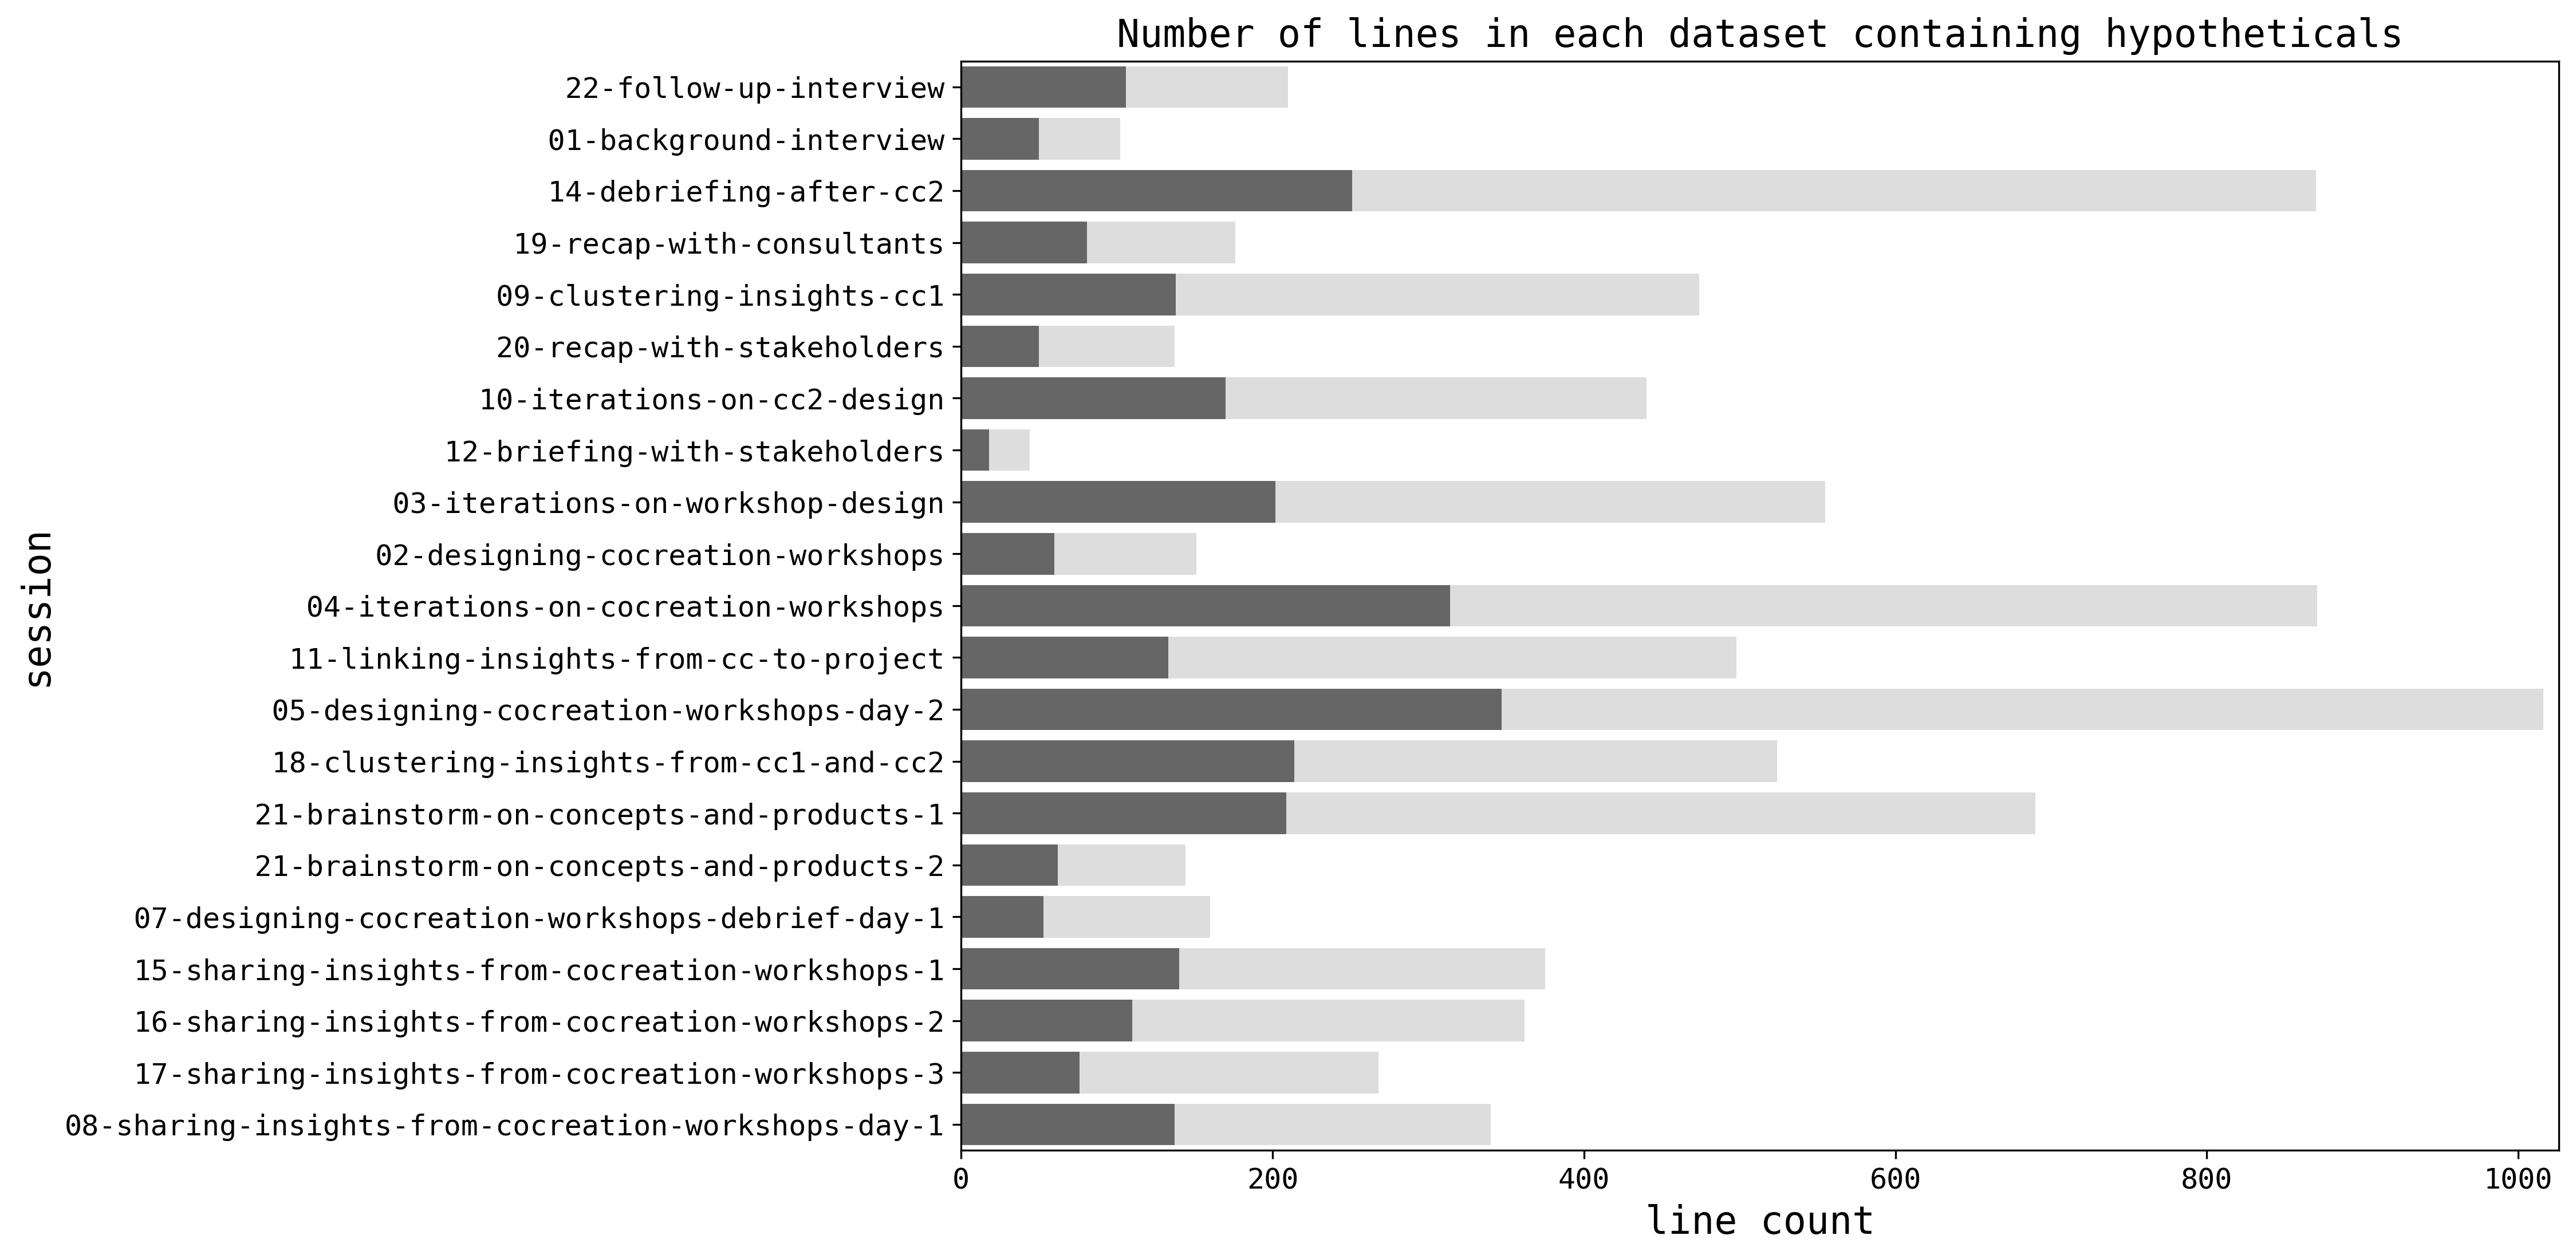

In [23]:
plot_sessions(df, 'dtrs-11', percentage=False)

## Plot subsets of sessions
This is more relevant to the DTRS-10 and DTRS-11 datasets. Identify session subsets (e.g. all graduate sessions in DTRS-10, all sessions with Jin in DTRS-10, all co-creation-related sessions in DTRS-11) and plot them.

In [24]:
def plot_session_subsets(df, subset_string, dataset_name, percentage=True):
    df_dataset = session_counts(df, dataset_name)
    df_subset = df_dataset[df_dataset.session.str.contains(subset_string)]
    bar_width = 0.4
    num_bars = len(set(list(df_subset.session)))
    plot_height = num_bars * bar_width
    fig, ax = plt.subplots(figsize=(12, plot_height), dpi=300)
    if percentage :
        bars = sns.barplot(x = 'percentage', y = 'session', color = "#dddddd",
                           data = df_subset[df_subset.type == 'total'])
        bars = sns.barplot(x = 'percentage', y = 'session', color = overall_hyp_color,
                           data = df_subset[df_subset.type == 'hypotheticals'])
        xmin = min(list(df_subset.percentage))
        xmax = max(list(df_subset.percentage)) * 1.01
        bars.set_xlim([xmin, xmax])
        bars.set_title("Percentage of lines w/ hypotheticals filtered by '"+subset_string+"'",
                       fontsize=16)
    else :
        bars = sns.barplot(x = 'line count', y = 'session', color = "#dddddd",
                           data = df_subset[df_subset.type == 'total'])
        bars = sns.barplot(x = 'line count', y = 'session', color = overall_hyp_color,
                           data = df_subset[df_subset.type == 'hypotheticals'])
        xmin = min(list(df_subset['line count']))
        xmax = max(list(df_subset['line count'])) * 1.01
        bars.set_xlim([xmin, xmax])
        bars.set_title("Number of lines w/ hypotheticals filtered by '"+subset_string+"'",
                       fontsize=16)

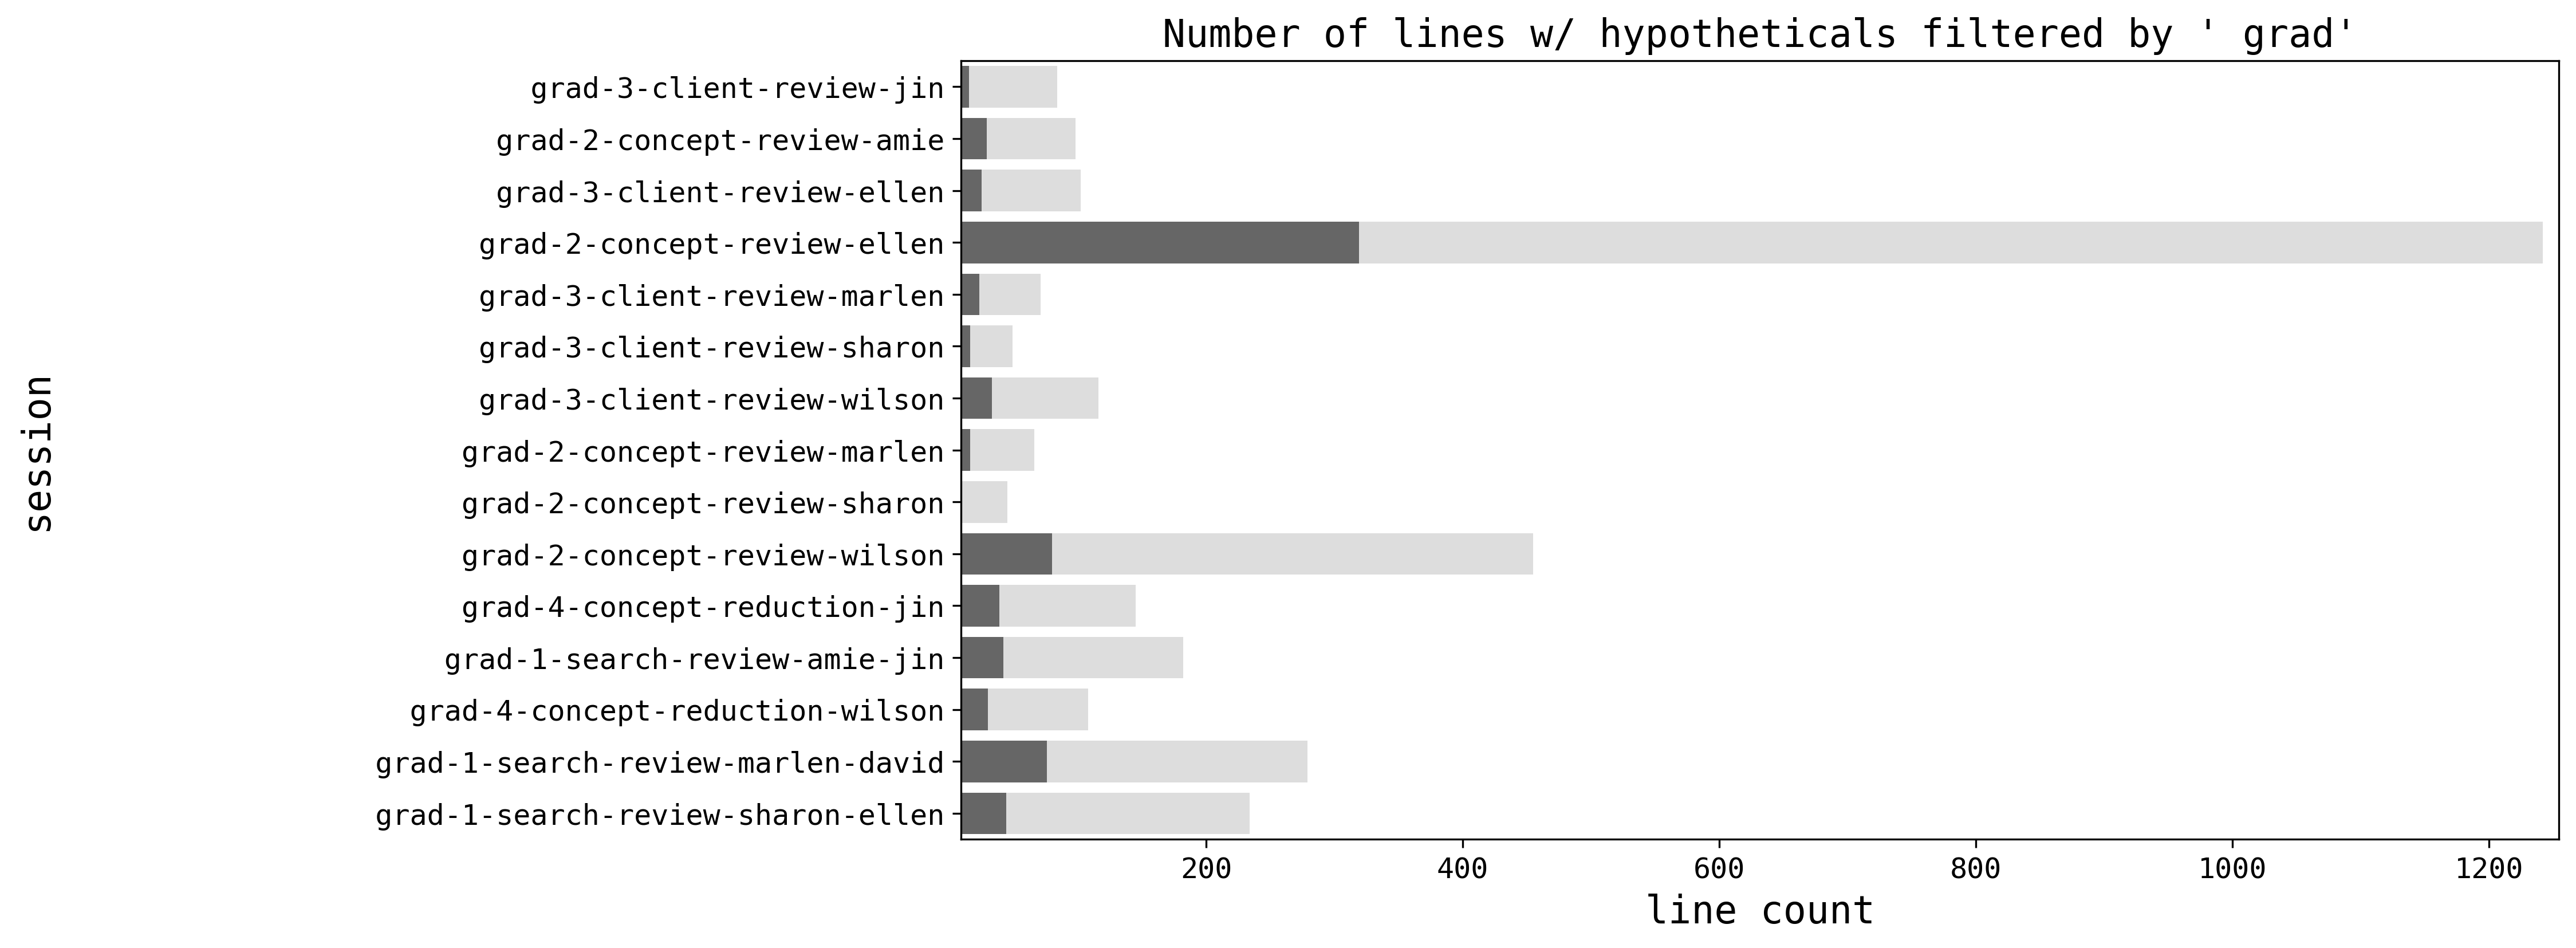

In [25]:
plot_session_subsets(df, ' grad', 'dtrs-10', percentage=False)


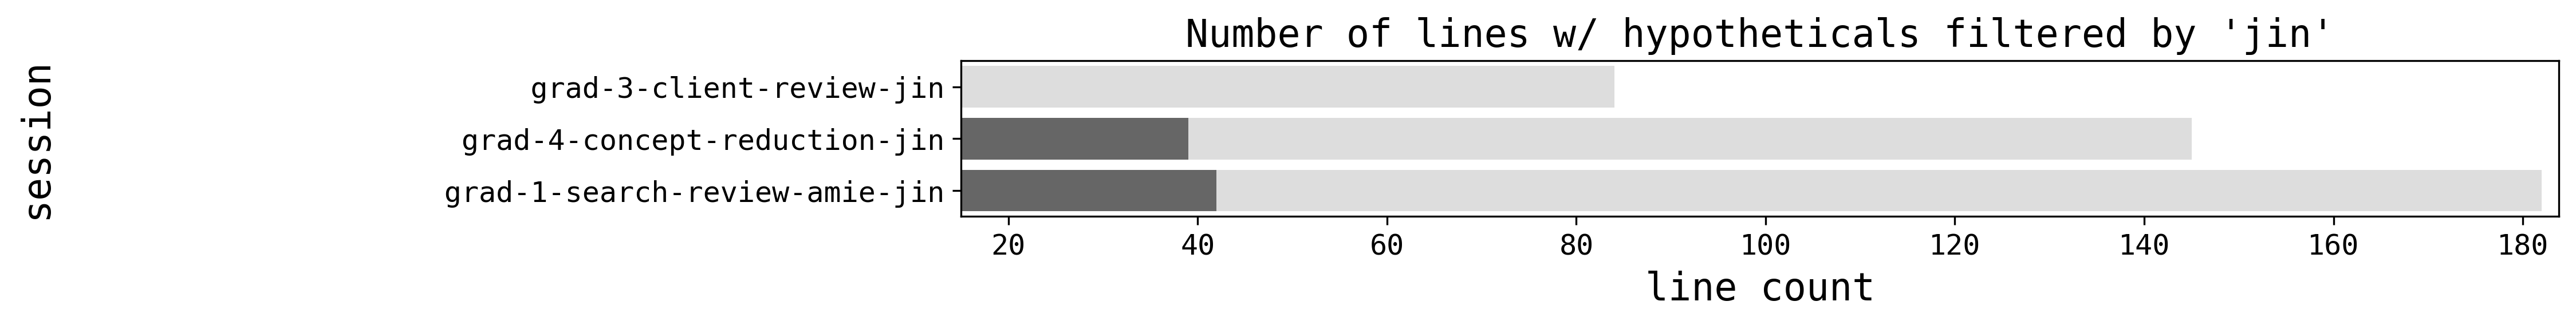

In [26]:
plot_session_subsets(df, 'jin', 'dtrs-10', percentage=False)

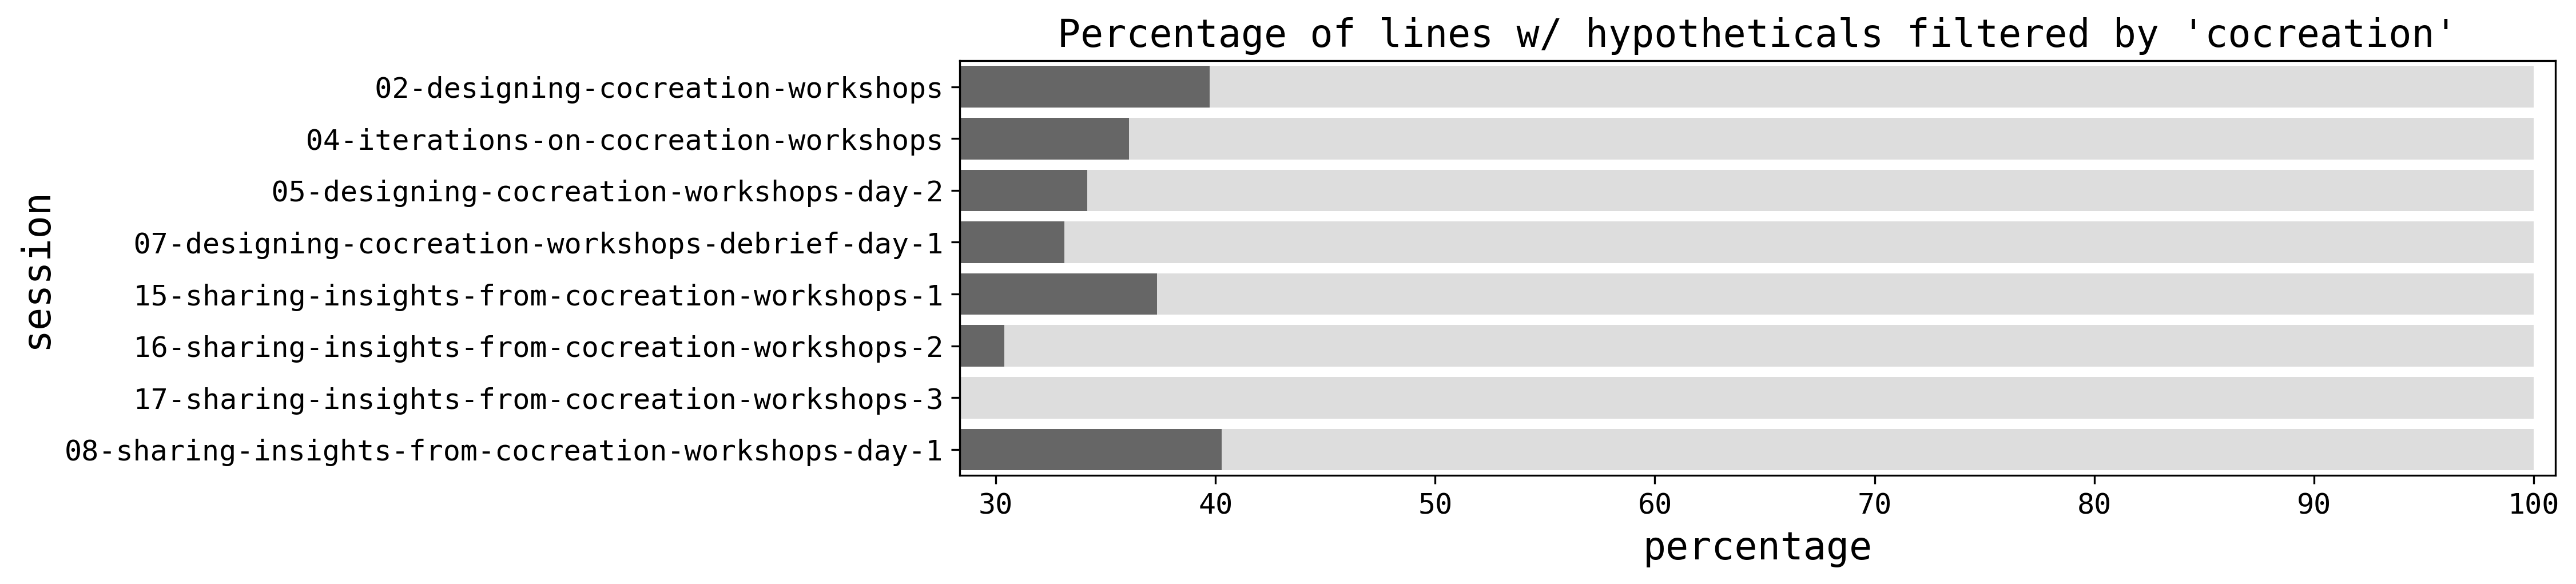

In [27]:
plot_session_subsets(df, 'cocreation', 'dtrs-11', percentage=True)

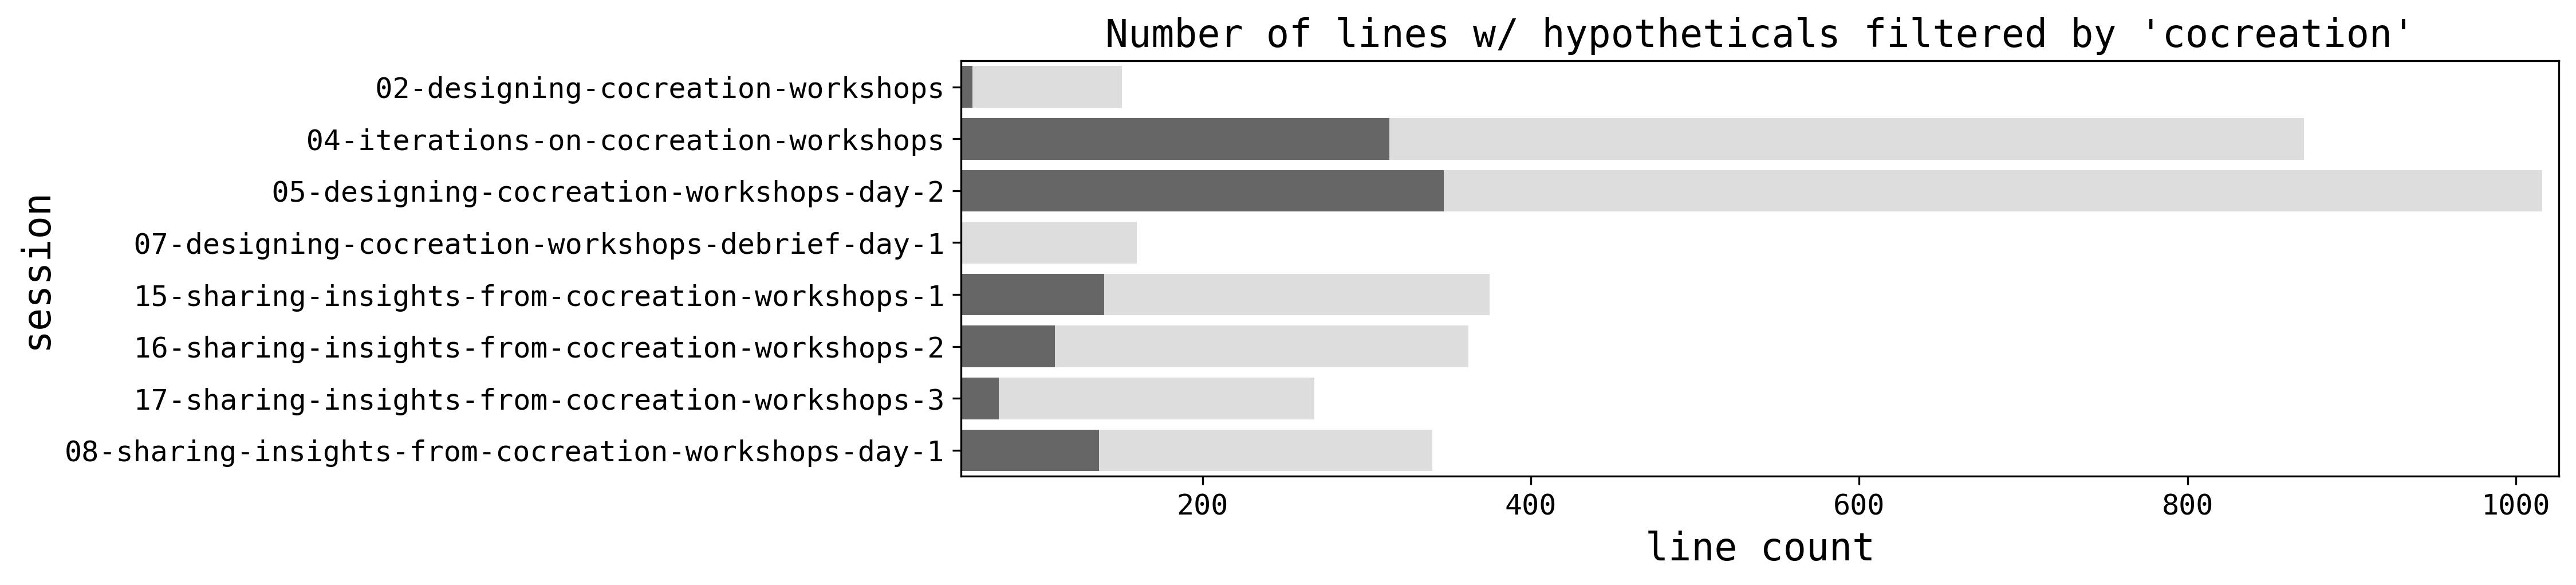

In [28]:
plot_session_subsets(df, 'cocreation', 'dtrs-11', percentage=False)

## Transportation-Related Terms
Get a list of transportation-related terms from Empath (see other notebook) and plot them instead of hypotheticals

In [29]:
transportation_terms = ["hop", "ride", "walk", "dive", "swim", "crawl", "pedal", "sail", "race",
                        "drive", "ski", "fly", "jump", "row", "zip", "paddle", "jog", "cruise",
                        "climb", "glide", "hike", "go", "sprint", "circle", "bump", "move",
                        "wander", "skate", "park", "plow", "paddling", "crash", "hurry",
                        "travel", "chase", "sneak", "tow", "dash", "haul", "drift", "fish",
                        "hustle", "pull", "leap", "land", "scoot", "slip", "dart", "lug",
                        "board", "wade", "hoist", "bounce", "strap", "slide", "clamber",
                        "gallop", "blast", "stretch", "paddled", "roll", "descend", "skis",
                        "venture", "stagger", "stroll", "rush", "swing", "dribble", "hook",
                        "splash", "limp", "maneuver", "tuck", "swoop", "wheel", "pack",
                        "buckle", "trudge", "paddle", "stow", "trip", "bike", "kick", "bike",
                        "get", "hug", "drag", "roar", "stay", "zoom", "float", "shoot", "amble",
                        "catch", "jam", "wiggle", "sink", "suck", "sit"]

In [30]:
# df_trans = add_count(df_init, 'transportation', transportation_terms)
# df_trans = add_every_count(df_init, 'transportation', transportation_terms)

# Other Data to Plot
 - Same as above, but for "transportation"
 - (look up what happens in Vegas dataset)
 - Do above for ALL of the data (not separated by dataset)
 - Consider individual "hypothetical" indicator and plot them separately.
 - ~Add KWIC to the above~
 - Add "memory" keywords "recall", "remember", "used to"
 - Tense analysis in general (for past tense)
 - Sentiment analysis, then look specifically for "agreement", "judgment" terms
 - Word cloud for each dataset (remove selective stop words)
 - What constitutes "grammar of a design conversation"?
 - Make a list of "concrete" nouns in each dataset. 

# For InferKit
Send Peter stripped-down datasets separately (**Done**), and with duplication (with same number of lines) 

In [37]:
utt = df_init['utterance']

# for ind, line in enumerate(utt) :
#     if " courage" in line :
#         print(ind, line)

In [32]:
df_init[12270:12275]

,dataset,session,speaker,utterance,hypotheticals
12270,dtrs-11,09-clustering-insight...,Abby,But I guess it's- you will only be elevated if...,4
12271,dtrs-11,09-clustering-insight...,Ewan,"[Oh, no no clearly], that's a core value, so t...",4
12272,dtrs-11,09-clustering-insight...,Abby,Yeah.,0
12273,dtrs-11,09-clustering-insight...,Ewan,"And of course there will be a point, and, you ...",12
12274,dtrs-11,09-clustering-insight...,Abby,"[Yeah but I guess it's] almost the opposite, b...",5


In [33]:
len(set(list(df[df['dataset'] == 'dtrs-11']['session'])))

21

In [34]:
ll = 'mary had a little lamb, its fleece was white as snow.'.split()
ll_str = ' '.join(ll)
print(ll)
print(ll_str)

['mary', 'had', 'a', 'little', 'lamb,', 'its', 'fleece', 'was', 'white', 'as', 'snow.']
mary had a little lamb, its fleece was white as snow.


In [35]:
def get_stats(df_input, dataset):
    df = df_input[df_input['dataset']==dataset]
    sessions = list(set(list(df['session'])))
    token_count_list = []
    total_token_count = 0
    for session in sessions :
        df_session = df[df['session']==session]
        utterances = list(df_session['utterance'])
        utt_str = ' '.join(utterances)
        utt_tokens = utt_str.split()
        num_tokens = len(utt_tokens)
        token_count_list.append(num_tokens)
        total_token_count += num_tokens
    tokens_mean = statistics.mean(token_count_list)
    tokens_sd = statistics.stdev(token_count_list)
    print("Stats for",dataset, ":")
    print("Number of sessions:", len(sessions))
    print("Total tokens =", total_token_count)
    print("Mean tokens per session =", round(tokens_mean))
    print("Std. Dev. of tokens =", round(tokens_sd))
    
        
    

In [36]:
get_stats(df, 'dtrs-11')

Stats for dtrs-11 :
Number of sessions: 21
Total tokens = 179955
Mean tokens per session = 8569
Std. Dev. of tokens = 4527


In [94]:

nlp = spacy.load("en_core_web_sm")



[1, 2, 3]

In [196]:

datasets = list(set(list(df.dataset)))

def liwc_counts_by_dataset(df, dataset, liwc_tentative):
    liwc_collection = [{'word' : word, 'count' : 0, 'count_ratio': 0.0, 'dataset' : dataset } for word in liwc_tentative]
    utterances = df[df.dataset == dataset]['utterance']
    dataset_text = ' '.join(utterances)
    doc = nlp(dataset_text)
    tokens = [token.string.strip().lower() for token in doc]
    total_words = len(tokens)
    word_counts = Counter(tokens)
    for word_obj in liwc_collection :
        word = word_obj['word']
        if word in liwc_tentative :
            word_obj['count'] = word_counts[word]
            word_obj['count_ratio'] = word_counts[word]/total_words
    liwc_counts_df = pd.DataFrame(liwc_collection)
    liwc_counts_sorted_df = liwc_counts_df.sort_values('word')
    return liwc_counts_sorted_df
    
all_liwc_counts_df = pd.DataFrame(columns = ['word', 'count', 'count_ratio', 'dataset'])

for dataset in datasets:
    counts_dataset_df = liwc_counts_by_dataset(df, dataset, liwc_tentative)
    print(counts_dataset_df.shape)
    all_liwc_counts_df = all_liwc_counts_df.append(counts_dataset_df)



(148, 4)
(148, 4)
(148, 4)
(148, 4)


In [155]:
all_liwc_counts_df.shape

(592, 4)

In [233]:
all_liwc_counts_df_filtered = pd.DataFrame(columns = ['word', 'count', 'count_ratio', 'dataset'])
words = list(set(all_liwc_counts_df['word']))

all_liwc_counts_df_filtered.drop(all_liwc_counts_df_filtered.index, inplace=True)

for ww in words :
    w_df = all_liwc_counts_df[all_liwc_counts_df.word == ww]
    count_sum = sum(list(w_df['count']))
    if count_sum > 0 :
        all_liwc_counts_df_filtered = all_liwc_counts_df_filtered.append(w_df)

all_liwc_counts_sorted_df_filtered = all_liwc_counts_df_filtered.sort_values('word')
print(len(words))
print(all_liwc_counts_df.shape)
print(all_liwc_counts_df_filtered.shape)
print(all_liwc_counts_df_filtered.shape[0]/4, "words")

148
(592, 4)
(568, 4)
142.0 words


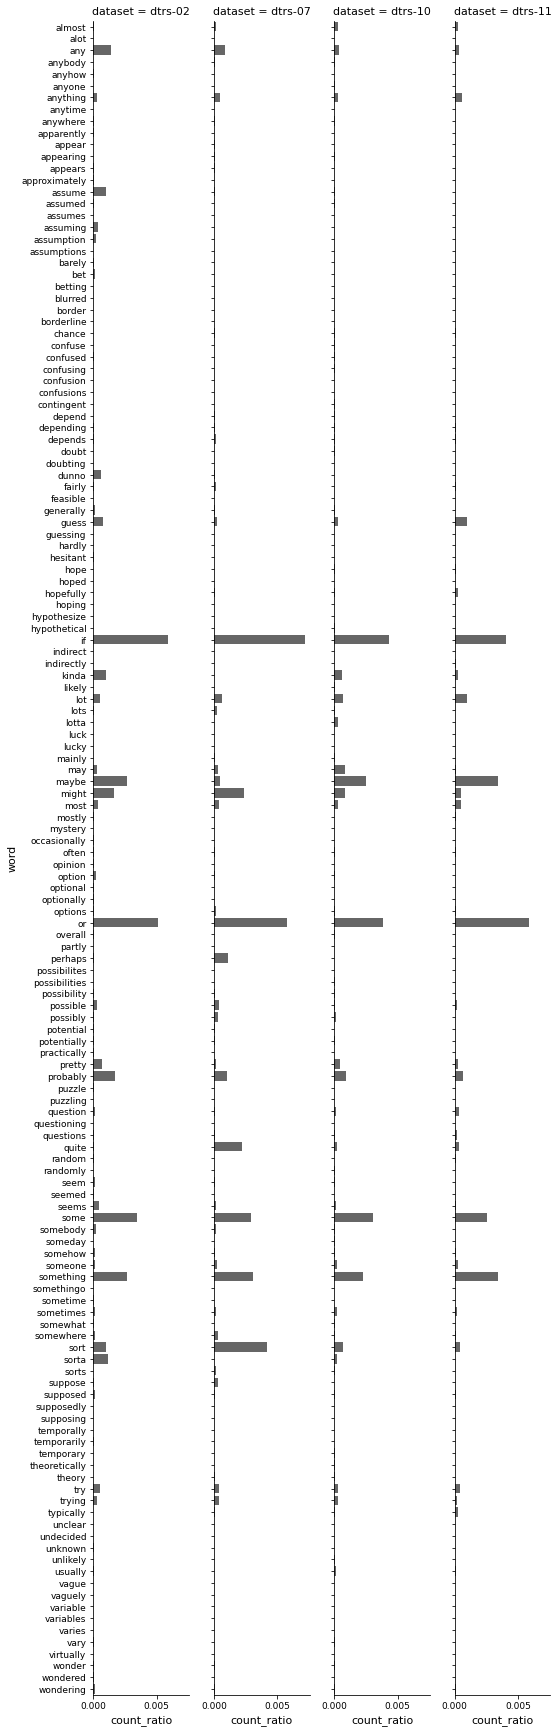

In [239]:
rcParams['font.family'] = 'sans serif'
rcParams['font.size'] = 11
rcParams['xtick.labelsize'] = 9
rcParams['ytick.labelsize'] = 9
rcParams['axes.titlesize'] = 12
# fig, ax = plt.subplots(figsize=(12, 20), dpi=300)
bars = sns.catplot(x = 'count_ratio', y = 'word', col="dataset",
                   color = "#666666",kind="bar",
                   data = all_liwc_counts_sorted_df_filtered,
                   height=24, aspect=0.08, col_order= ['dtrs-02', 'dtrs-07', 'dtrs-10', 'dtrs-11'])
plt.savefig('plots/liwc_distribution_datasets.pdf', dpi=300, bbox_inches='tight')

In [148]:
len(liwc_tentative)

148